In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../pytorch-unet-segmentation-master/scripts/")
sys.path.append("../pytorch-unet-segmentation-master/src/")
import Classic

# Importar imágenes
r = c = 190
w = h = 388
img = cv2.imread('../pytorch-unet-segmentation-master/imagenes_pruebapre/0.png', 
                 cv2.IMREAD_GRAYSCALE)[r:r+h, c:c+w]
label = cv2.imread('../pytorch-unet-segmentation-master/imagenes_pruebapre/0_mask.png', 
                   cv2.IMREAD_UNCHANGED)[r:r+h, c:c+w, 3] == 0
label = cv2.morphologyEx(label.astype('uint8'), cv2.MORPH_ERODE, 
                         kernel=np.ones((3,3),np.uint8), 
                         iterations=1)

label_tensor = torch.from_numpy(label.astype('int64'))
criterion = nn.BCELoss()

Predicciones usando modelo clásico



<IPython.core.display.Javascript object>


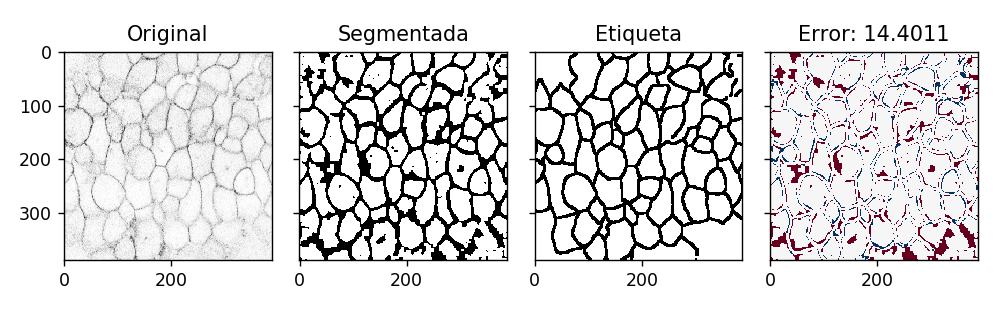

In [2]:
img_pre1 = Classic.normalize_image(255-img)
img_pre1 = Classic.denoise_image(img_pre1)
preds1 = ~Classic.get_binary_mask(img_pre1, close_iter=2)/255.

loss1 = criterion(torch.from_numpy(preds1).float(), label_tensor.float()).item()

fig, ax = plt.subplots(1, 4, figsize=(8, 2.5), tight_layout=True,
                       sharex=True, sharey=True)
for k, im_plot in enumerate([img, preds1, label]):
    ax[k].imshow(im_plot, cmap=plt.cm.Greys_r)
ax[-1].imshow(label - preds1, cmap=plt.cm.RdBu_r)
ax[0].set_title('Original')
ax[1].set_title('Segmentada')
ax[2].set_title('Etiqueta')
ax[3].set_title(f'Error: {loss1:0.4f}');

Predicciones usando Red Neuronal

<IPython.core.display.Javascript object>


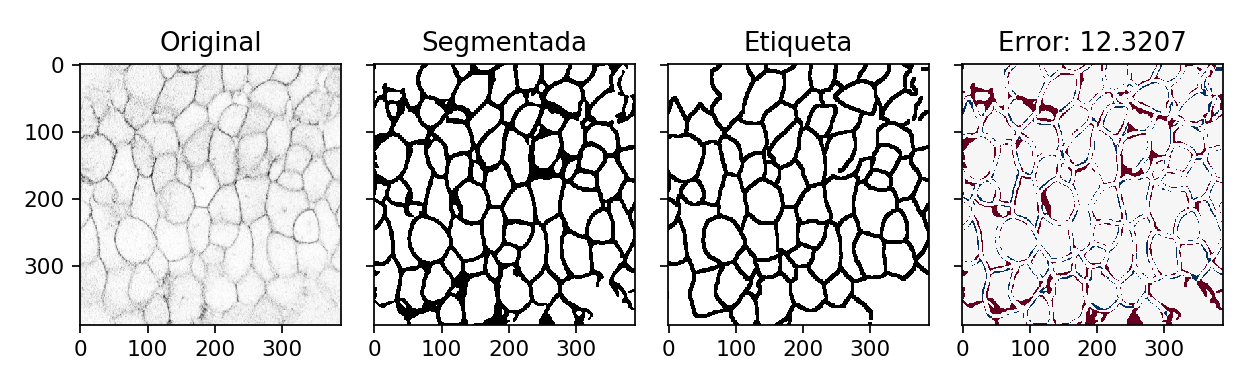

In [5]:
# Modelo y definiciones
model = torch.load('../pytorch-unet-segmentation-master/modelos/model_epoch_440.pwf', 
                   map_location=torch.device('cpu')).module.cpu()
model.eval();

my_transforms = transforms.Compose([transforms.Pad(padding=(572-w)//2, 
                                                   padding_mode='reflect'),
                                    transforms.ToTensor()])

def post_process(img, ks=1):
    kernel = np.ones((ks, ks), np.uint8)
    ret, bin_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    closing = cv2.morphologyEx(bin_image, cv2.MORPH_CLOSE, kernel, iterations=1)
    return torch.from_numpy(closing).float()/255.

# Preprocesar
img_pre2 = cv2.bilateralFilter(img.copy(), 5, 75, 75)
img_pre2 = cv2.equalizeHist(img_pre2)
# Transformar con torch
im_pil = Image.fromarray(img_pre2)
img_tensor = my_transforms(im_pil)
# Evaluar con U-net
with torch.no_grad():
    output = model.forward(img_tensor.unsqueeze(0))
    preds2 = torch.argmax(output, dim=1).float()
    preds2 = post_process(preds2[0].detach().numpy().astype('uint8')*255, ks=3)
    loss2 = criterion(preds2, label_tensor.float().unsqueeze(0)).item()
preds2 = preds2.squeeze(0).numpy()

fig, ax = plt.subplots(1, 4, figsize=(8, 2.5), tight_layout=True,
                       sharex=True, sharey=True)
for k, im_plot in enumerate([img, preds2, label]):
    ax[k].imshow(im_plot, cmap=plt.cm.Greys_r)
ax[-1].imshow(label - preds2, cmap=plt.cm.RdBu_r)
ax[0].set_title('Original')
ax[1].set_title('Segmentada')
ax[2].set_title('Etiqueta')
ax[3].set_title(f'Error: {loss2:0.4f}');